In [1]:
from simforest import SimilarityForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bias import create_correlated_feature, get_permutation_importances, bias_experiment

sns.set_style('whitegrid')

SEED = 42

import warnings
warnings.filterwarnings('ignore')

# Read the data

In [2]:
X, y = load_svmlight_file('data/heart')
X = X.toarray().astype(np.float32)


features = [f'f{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns = features)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


# Add new feature

Create synthetic column, strongly correlated with target.
Each value is calculated according to the formula:
    v = y * a + random(-b, b)
    So its scaled target value with some noise.

Then a fraction of values is permuted, to reduce the correlation.

In this case, a=10, b=5, fraction=0.05

In [3]:
new_feature, corr, p = create_correlated_feature(y, fraction=0.05, seed=SEED, verbose=True)
df = pd.concat([pd.Series(new_feature, name='new_feature'), df], axis=1)
df.head()

Initial new feature - target correlation, without shuffling: 0.962, p: 0.0
New feature - target correlation, after shuffling: 0.906, p: 0.0


,new_feature,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,8.745401,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,-5.492857,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,12.319939,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,-9.013415,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,-13.439814,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


# Biased Random Forest feature importance

Random Forest offers a simple way to measure feature importance. A certain feature is considered to be important if it reduced node impurity often, during fitting the trees.

We can see that adding a feature strongly correlated with target improved the model's performance, compared to results we obtained without this feature. What is more, this new feature was really important for the predictions. The plot shows that it is far more important than the original features.

Random Forest f1 score: 0.97


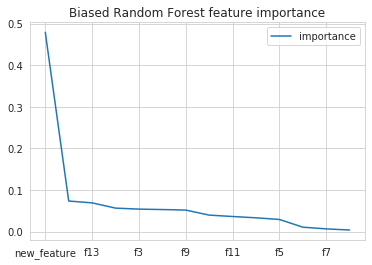

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(f'Random Forest f1 score: {round(f1_score(y_test, rf_pred), 3)}')

df_rf_importances = pd.DataFrame(rf.feature_importances_, index=df.columns.values, columns=['importance'])
df_rf_importances = df_rf_importances.sort_values(by='importance', ascending=False)
df_rf_importances.plot()
plt.title('Biased Random Forest feature importance');

# Permutation feature importance

The impurity-based feature importance of Random Forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

Futhermore, Random Forest feature importance is biased towards high-cardinality numerical feautures.

In this experiment, we will use permutation feature importance to asses how Random Forest and Similarity Forest
depend on syntetic feauture. This method is more reliable, and enables to measure feature importance for Similarity Forest, that doesn't enable us to measure impurity-based feature importance.

Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

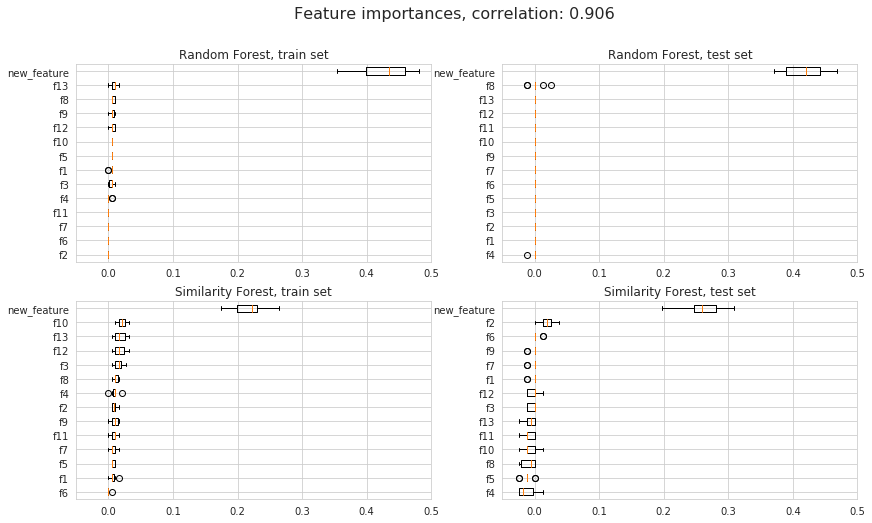

In [5]:
sf = SimilarityForestClassifier(n_estimators=100, random_state=SEED).fit(X_train, y_train)

perm_importance_results = get_permutation_importances(rf, sf, 
                                                      X_train, y_train, X_test, y_test, 
                                                      corr, df.columns.values, plot=True)

In [6]:
fraction_range = [0.0, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.12, 0.15, 
                  0.18, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


correlations, rf_scores, sf_scores, permutation_importances = bias_experiment(df, y, fraction_range, SEED)

19it [35:03, 110.74s/it]


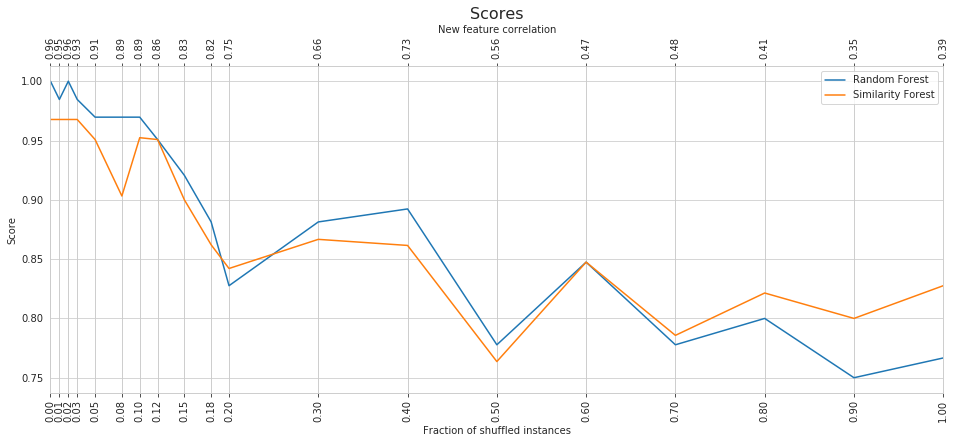

In [7]:
def tick_function(correlations):
    return [round(c, 2) for c in correlations]

# Set figure and first axis
fig, ax1 = plt.subplots(figsize=(16, 6))
plt.xticks(rotation=90)
ax1.set_xticks(fraction_range)
ax1.set_xlim(0.0, 1.0)
ax1.set_xlabel('Fraction of shuffled instances')

# Set second axis
ax2 = ax1.twiny()
plt.xticks(rotation=90)
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(0.0, 1.0)
ax2.set_xticklabels(tick_function(correlations))
ax2.set_xlabel('New feature correlation')

# Plot
plt.plot(fraction_range, rf_scores, label='Random Forest')
plt.plot(fraction_range, sf_scores, label='Similarity Forest')

# Set legend and titles
plt.legend()
ax1.set_ylabel('Score')
plt.title('Scores', fontsize=16);

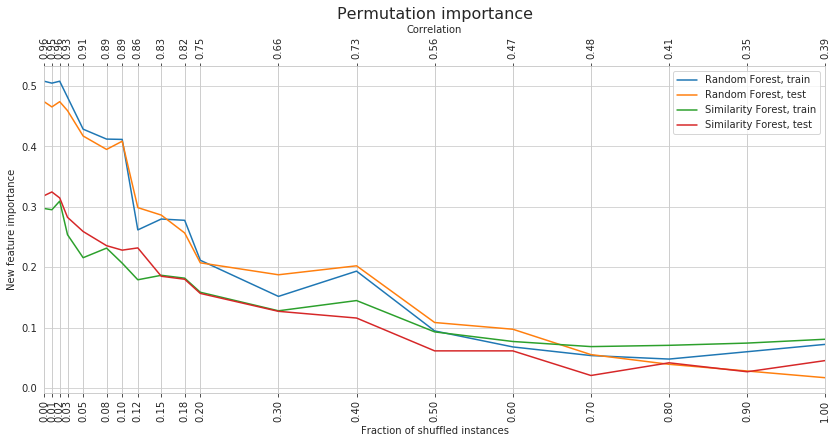

In [8]:
df_permutation_importances = pd.DataFrame(permutation_importances)

# Set figure and first axis
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.xticks(rotation=90)
ax1.set_xticks(fraction_range)
ax1.set_xlim(0.0, 1.0)
ax1.set_xlabel('Fraction of shuffled instances')

# Set second axis
ax2 = ax1.twiny()
plt.xticks(rotation=90)
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(0.0, 1.0)
ax2.set_xticklabels(tick_function(correlations))
ax2.set_xlabel('Correlation')

# Plot
plt.plot(fraction_range, df_permutation_importances['rf_train'].values, label='Random Forest, train')
plt.plot(fraction_range, df_permutation_importances['rf_test'].values, label='Random Forest, test')
plt.plot(fraction_range, df_permutation_importances['sf_train'].values, label='Similarity Forest, train')
plt.plot(fraction_range, df_permutation_importances['sf_test'].values, label='Similarity Forest, test')

# Set legend and titles
plt.legend()
ax1.set_ylabel('New feature importance')
plt.title('Permutation importance', fontsize=16);